# **Punto 1 (parte 2)**

In [1]:
import warnings
warnings.filterwarnings('ignore')
import mglearn
import pandas as pd
import matplotlib.pyplot as plt  
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn import neighbors
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import r2_score
from sklearn.metrics import explained_variance_score
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
import seaborn as sns

**Boston Housing**: (LinearRegression, KNN). Utilice la métrica R2 y RMSE durante la evaluación y
selección del modelo. Los resultados deben ser presentados usando el Cuadro 2. Realice un gráfico
en el que muestre en los conjuntos de entrenamiento y test, el precio original y el predicho. El
estudiante que obtenga el mejor score con esta métrica, será premiado con una décima para el
corte. Los datos deben ser cargados mediante el siguiente par de líneas:

In [2]:
X, y = mglearn.datasets.load_extended_boston()

In [3]:
X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, random_state=21)

## ***(i) Manual***

**K-NN**

In [4]:
best_score = -np.inf

# Iterar sobre los diferentes valores de n_neighbors
for k in [1, 3, 5, 10, 15, 20, 25,28]:
    scores = []

    for train_index, val_index in KFold(n_splits=5).split(X_trainval):
        # Dividir los datos en conjuntos de entrenamiento y validación
        X_train, X_val = X_trainval[train_index], X_trainval[val_index]
        y_train, y_val = y_trainval[train_index], y_trainval[val_index]

        # Escalar los datos de entrenamiento y validación sin fuga de información
        scaler = MinMaxScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_val_scaled = scaler.transform(X_val)

        knn = KNeighborsRegressor(n_neighbors=k)
        knn.fit(X_train_scaled, y_train)

        # Score del modelo sobre los datos de validación
        score = knn.score(X_val_scaled, y_val)
        scores.append(score)

    # Calcular la media de los scores de la validación cruzada
    mean_score = np.mean(scores)

    # Actualizar el mejor score y los mejores parámetros si es necesario
    if mean_score > best_score:
        best_score = mean_score
        best_parameters = {'K': k}

print("Mejores parámetros: ", best_parameters)
print("Mejor score: ", best_score)

Mejores parámetros:  {'K': 1}
Mejor score:  0.6995977333374492


De la lista de parametros de *k* el GrisSearch con validación crusada a mano, arrojo que el mejor modelo es aquel que obtuvo score $r^2$ de 0.70 aproximadamente y parametro k=1.

**Linearegresion**

In [5]:
best_r2_score = -np.inf  # Para almacenar el mejor R^2

# Definir el número de pliegues
kf = KFold(n_splits=5)

# Lista para almacenar los scores de R^2 en cada pliegue
r2_scores = []

# Iterar sobre los pliegues de la validación cruzada
for train_index, val_index in kf.split(X_trainval):
    # Dividir los datos en conjuntos de entrenamiento y validación
    X_train, X_val = X_trainval[train_index], X_trainval[val_index]
    y_train, y_val = y_trainval[train_index], y_trainval[val_index]

    # Escalar los datos sin fuga de información
    scaler = MinMaxScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)

    # Entrenar el modelo de regresión lineal
    model = LinearRegression()
    model.fit(X_train_scaled, y_train)

    # Realizar predicciones en el conjunto de validación
    y_pred = model.predict(X_val_scaled)

    # Calcular el score R^2
    r2 = r2_score(y_val, y_pred)
    r2_scores.append(r2)

# Obtener el mejor R^2 score promedio
mean_r2 = np.mean(r2_scores)

print("Mejor R^2 score: ", mean_r2)

Mejor R^2 score:  0.7752680272499475


Al realizar la validación crusada para el modelo de regresión lineal manual, el mejor score que se obtuvo fue de 0.77 en el $r^2$.

## ***(i) GridSearch - pipeline***

**K-NN**

In [6]:
pipeline = Pipeline([('scaler', MinMaxScaler()), ('knn', KNeighborsRegressor())])

param_grid = {
    'knn__n_neighbors': [1,3,5, 10, 15, 20, 25,28] 
}

grid_search_k = GridSearchCV(estimator=pipeline,param_grid=param_grid,cv=5,scoring='r2',n_jobs=-1)

# Entrenar el GridSearchCV con los datos de entrenamiento
grid_search_k.fit(X_trainval, y_trainval)

# Obtener los mejores parámetros y el mejor score
best_parameters = grid_search_k.best_params_
best_score = grid_search_k.best_score_

pred_y=grid_search_k.predict(X_test)
print("Mejores parámetros: ", best_parameters)
print("Mejor score : ", best_score)

Mejores parámetros:  {'knn__n_neighbors': 1}
Mejor score :  0.6995977333374492


Al hacer uso de la función GridSearchCV y de un pipeline vemos que obtuvimos resultados al hacer el proceso de forma manual con el mejor parametro *k*=1 y un score de 0.70 aproximadamente.

**LinearRegresion**

In [7]:
# Definir el pipeline con escalado y modelo LinearRegression
pipeline = Pipeline([('scaler', MinMaxScaler()), ('regressor', LinearRegression())])

# Definir el GridSearchCV para R^2
grid_search = GridSearchCV(estimator=pipeline,param_grid={},cv=5, scoring='r2')

# Entrenar el GridSearchCV con los datos de entrenamiento
grid_search.fit(X_trainval, y_trainval)

# Obtener los mejores parámetros y el mejor score
best_parameters = grid_search.best_params_
best_score = grid_search.best_score_

print("Mejores parámetros: ", best_parameters)
print("Mejor R^2 score: ", best_score)

Mejores parámetros:  {}
Mejor R^2 score:  0.7752680272499475


Vemos que por parte de la regresion lineal, tambien se obtuvo el mismo resultado del procedimiento manual, un score de 0.77.

## **Metricas mejores modelos**

In [8]:
model__pred_knn=grid_search_k.predict(X_test)
model_pred_RL=grid_search.predict(X_test)

tabla2={'':['K-NN','Regresion lineal'],
      'MAPE': [mean_absolute_percentage_error(y_test, model__pred_knn),mean_absolute_percentage_error(y_test, model_pred_RL)],
      'MAE':[mean_absolute_error(y_test, model__pred_knn),mean_absolute_error(y_test, model_pred_RL)],
      'RMSE': [np.sqrt(mean_squared_error(y_test, model__pred_knn)),np.sqrt(mean_squared_error(y_test, model_pred_RL))],
      'MSE':[mean_squared_error(y_test, model__pred_knn),mean_squared_error(y_test, model_pred_RL)],
      'R2': [r2_score(y_test, model__pred_knn),r2_score(y_test, model_pred_RL)]
      }

tabla=pd.DataFrame(tabla2)
tabla

,,MAPE,MAE,RMSE,MSE,R2
0,K-NN,0.152946,3.090551,4.617964,21.325591,0.748687
1,Regresion lineal,0.151045,2.649951,4.077296,16.624344,0.804089


**Conclusiones:**
Si analisamos los valores de las metricas de los modelos implementados podemos observar que en ambos modelos el MAPE y MAE son muy similares lo que indica que su rendimiento en termino del error absoluto promedio no es tan diferente, aunque la regresioón tenga valores un poco mas bajos.
Si análisamos de igual forma el RMSE y MSE vemos que la regresión lineal tiene valores mas bajos con respecto a los errores en la ptrdicción, Y así, como era de esperarse la regresion lineal tambien obtuvo un puntaje mas alto en el r^2 por tanto este modelo explica mejor la variabilidad de los datos.
Por tanto un modelo de regresión lineal en comparación es el modelo más adecuado para este conjunto de datos en particular.

## **Gráficas de predicción vs observado**

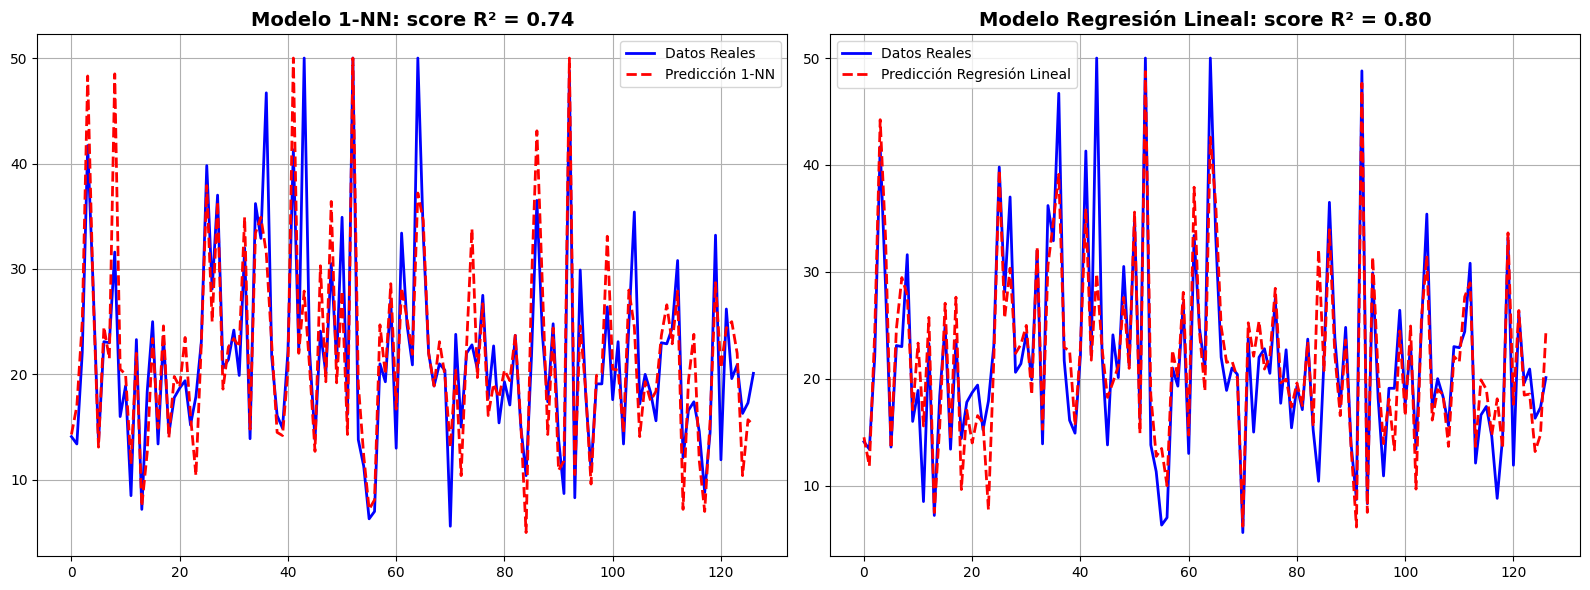

In [9]:

plt.figure(figsize=(16, 6))

# Gráfico del modelo 1-NN
plt.subplot(1, 2, 1)
sns.lineplot(x=range(len(y_test)), y=y_test, label='Datos Reales', color='blue', linewidth=2)
sns.lineplot(x=range(len(model__pred_knn)), y=model__pred_knn, label='Predicción 1-NN', color='red', linestyle='--', linewidth=2)
plt.title('Modelo 1-NN: score R² = 0.74', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True)

# Gráfico del modelo de regresión lineal
plt.subplot(1, 2, 2)
sns.lineplot(x=range(len(y_test)), y=y_test, label='Datos Reales', color='blue', linewidth=2)
sns.lineplot(x=range(len(model_pred_RL)), y=model_pred_RL, label='Predicción Regresión Lineal', color='red', linestyle='--', linewidth=2)
plt.title('Modelo Regresión Lineal: score R² = 0.80', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True)

# Ajustar el layout para que no se superpongan los elementos
plt.tight_layout()

# Mostrar la gráfica
plt.show()

En estas gráficas se evidencia lo que previamente discutimos acerca de la presición del modelo, vemos que la regresión lineal se ajusta mejor en los picos de los valores reales, mientras que en el modelo 1-NN sí existen fallas, estas gráficas son un soporte para evidenciar que efectivamente la regresión lineal se ajusta mejor a la variabilidad, información que arroja la metrica de r^2.